過去の感染者数と下水データから、効率的な感染者数予測を行う  
用いるデータはイギリスのもの(オープンアクセス)  
下水データは,異なる２つの下水処理施設で得られたものを使う

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/***
!pip install japanize_matplotlib
!pip install dtw-python

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import os
import math
import random

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

from scipy.interpolate import splrep, splev
from scipy.interpolate import BSpline, CubicSpline, make_smoothing_spline
from scipy.interpolate import interp1d
from scipy.stats import norm, skewnorm
from datetime import timedelta, datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA

# from pmdarima import arima
# from pmdarima import auto_arima
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

import tensorflow as tf
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import Model
from tensorflow import keras


from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.tsa.statespace import exponential_smoothing

from fast_DDTW._ddtw import *
from fast_DDTW._fastddtw import *

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)


評価に用いる関数を定義  
RMSE:二乗平均平方根誤差  
MAPE:平均絶対パーセント誤差  
MASE:平均絶対スケール誤差

In [4]:
def MASE(training_series, testing_series, prediction_series):
    n = training_series.shape[0]
    d = np.abs( np.diff( training_series.ravel()) ).sum()/(n-1)

    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d

def val(test_pred, test, train):
    rmse=np.sqrt(mean_squared_error(test_pred, test))
    mape=np.mean(np.abs((test_pred - test.to_numpy().reshape(-1,1)) / test.to_numpy().reshape(-1,1))) * 100
    mase=MASE(train.to_numpy().reshape(-1,1) , test.to_numpy().reshape(-1,1), test_pred)
    print("RMSE:", rmse)
    print("MAPE:", mape)
    print("MASE:", mase)
    return [rmse, mape, mase]

In [5]:
from get_data import get_data #感染者数や下水のコロナウイルス濃度をDataFrameで取得する関数

各列名の説明  
Case:感染者数  
Conc_S:下水のコロナウイルス濃度
Conc_D:下水のコロナウイルス濃度  
spl_S:下水のコロナウイルス濃度(スプライン補完で平滑化済み)  
spl_D:下水のコロナウイルス濃度(スプライン補完で平滑化済み)  
spl_S&D:spl_Sとspl_Dの平均  

S, D:下水処理施設がある地域の頭文字

データは週単位にリサンプリングした

In [ ]:
data_RNA = get_data()
data_RNA

 感染者数と下水データをプロットする  
 １枚目のグラフから,感染者数と下水データは後半部分でトレンドが異なることが分かる  
 ２枚目のグラフは, 感染者数と下水データの１階階差を表している

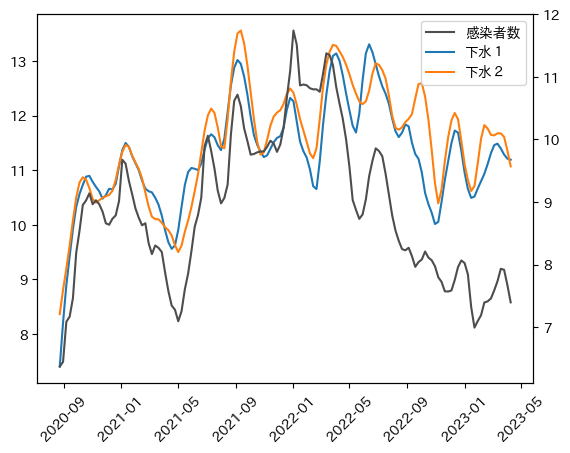

<Figure size 640x480 with 0 Axes>

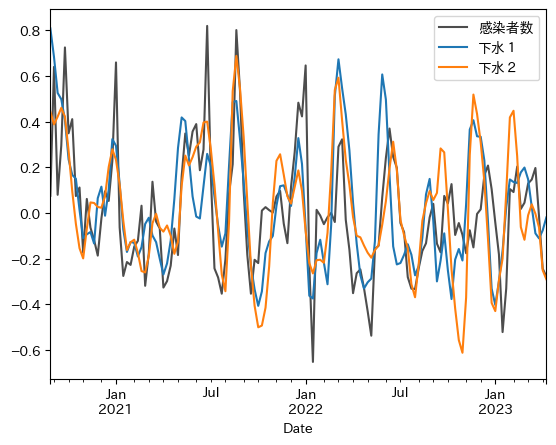

In [7]:
plt.figure()
lns1=plt.plot(data_RNA.loc[:,["spl_S"]], color="tab:blue", label="下水１")
lns2=plt.plot(data_RNA.loc[:,["spl_D"]], color="tab:orange", label="下水２")
plt.xticks(rotation=45)
plt.twinx()
lns3=plt.plot(data_RNA.loc[:,["Case"]], color="0.3", label="感染者数")
lns = lns3+lns1+lns2
labs = [l.get_label() for l in lns]
plt.xticks(rotation=45)
plt.legend(lns, labs)

plt.figure()
(data_RNA.loc[:,["Case", "spl_S", "spl_D"]].diff()[1:]).plot(color=["0.3","tab:blue","tab:orange"])
plt.legend(labs)


2種類の下水データをトレンドとトレンドを除去した成分に分ける

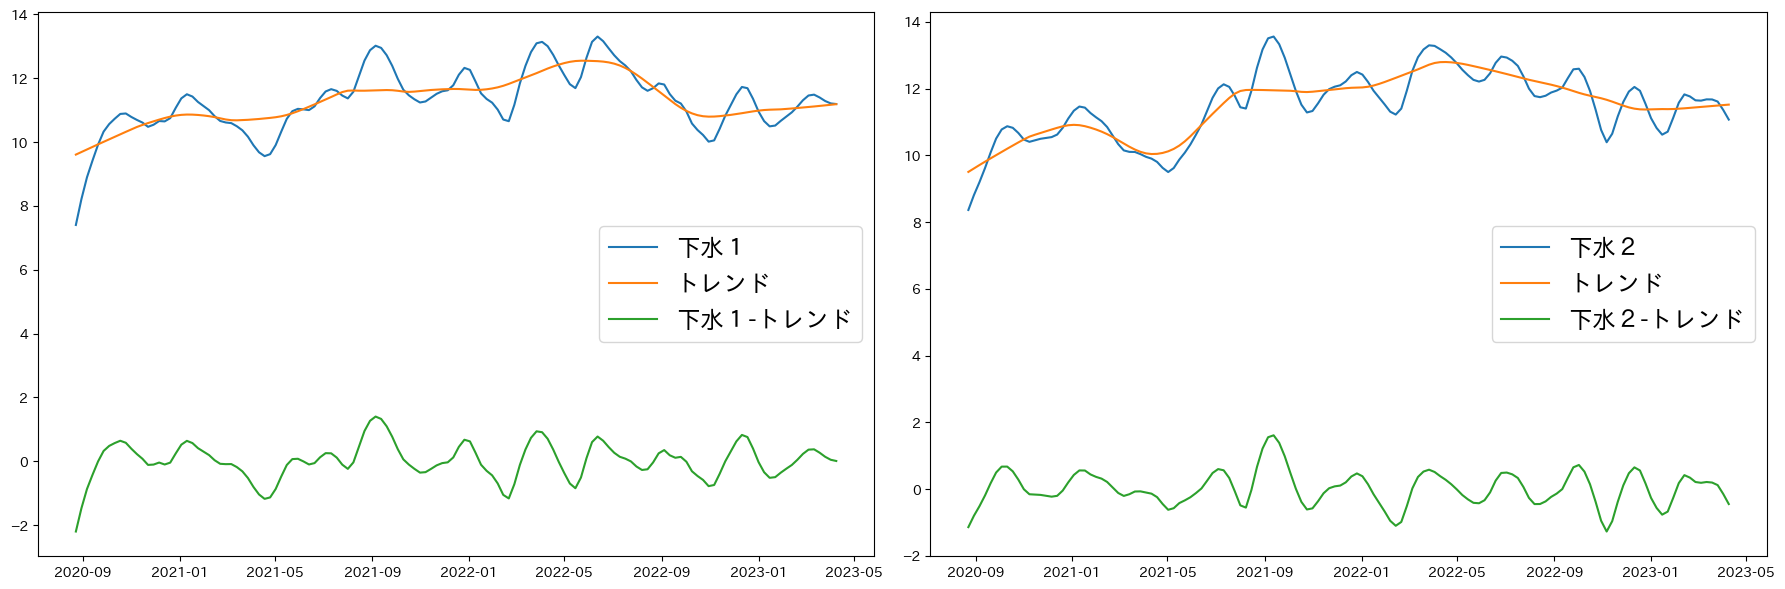

In [8]:
plt.figure(figsize=(18, 6))
# 下水１のプロット
plt.subplot(1, 2, 1)
stl_s = STL(data_RNA['spl_S'], period=12, robust=True)
stl_series_s = stl_s.fit()
plt.plot(stl_series_s.observed, label="下水１")
plt.plot(stl_series_s.trend, label="トレンド")
plt.plot(stl_series_s.observed - stl_series_s.trend, label="下水１-トレンド")
plt.legend(fontsize="xx-large")

# 下水２のプロット
plt.subplot(1, 2, 2)
stl_d = STL(data_RNA['spl_D'], period=12, robust=True)
stl_series_d = stl_d.fit()
plt.plot(stl_series_d.observed, label="下水２")
plt.plot(stl_series_d.trend, label="トレンド")
plt.plot(stl_series_d.observed - stl_series_d.trend, label="下水２-トレンド")
plt.legend(fontsize="xx-large")

# グラフを表示
plt.tight_layout()

感染者の予測はトレンドを除去したもので行う  
目的変数：感染者(トレンド除去)  
説明変数：感染者(トレンド除去)　下水データ２種(トレンド除去)

トレンドの予測は別途行う

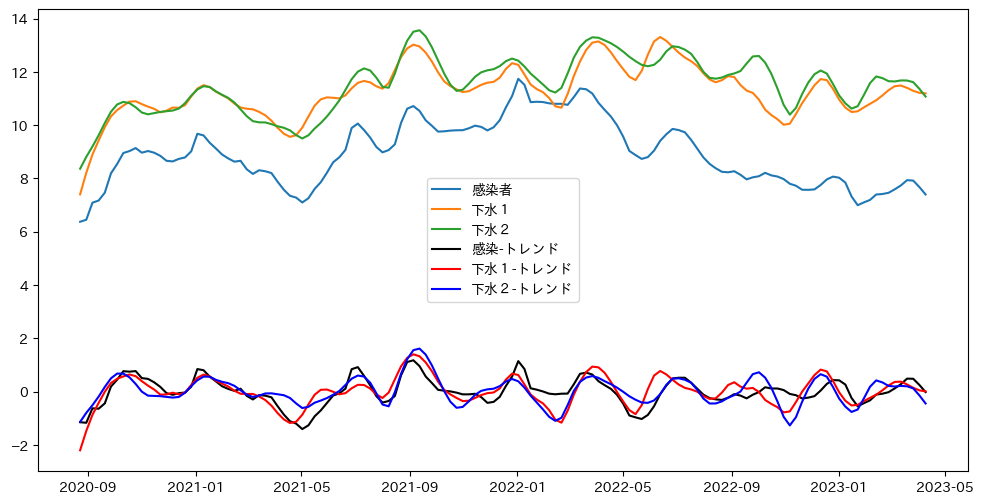

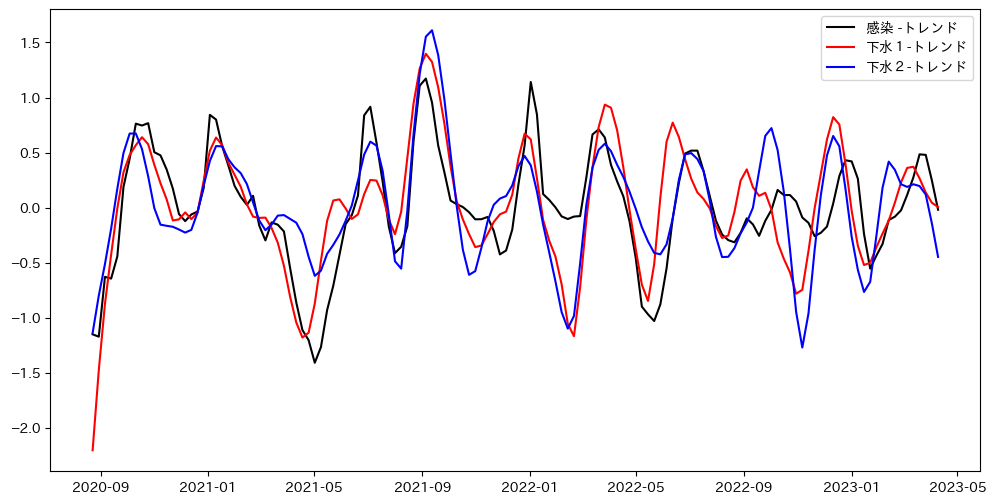

In [9]:
stl=STL(data_RNA['Case'],period=12, robust=True)
stl_series = stl.fit()
stl_s = STL(data_RNA['spl_S'], period=12, robust=True)
stl_series_s = stl_s.fit()
stl_d = STL(data_RNA['spl_D'], period=12, robust=True)
stl_series_d = stl_d.fit()

data_sea=pd.DataFrame(data={"Case_Seasonal":stl_series.observed-stl_series.trend})
data_sea["spl_S_Seasonal"]=stl_series_s.observed-stl_series_s.trend
data_sea["spl_D_Seasonal"]=stl_series_d.observed-stl_series_d.trend


plt.figure(figsize=(12,6))

plt.plot(stl_series.observed, label="感染者")
plt.plot(data_RNA[["spl_S", "spl_D"]], label=["下水１", "下水２"])

plt.plot(data_sea["Case_Seasonal"], "-k", label="感染-トレンド")

plt.plot(data_sea["spl_S_Seasonal"], "-r", label="下水１-トレンド")
plt.plot(data_sea["spl_D_Seasonal"], "-b", label="下水２-トレンド")
plt.legend()

plt.figure(figsize=(12,6))
plt.plot(data_sea["Case_Seasonal"], "-k", label="感染 -トレンド")
plt.plot(data_sea["spl_S_Seasonal"], "-r", label="下水１-トレンド")
plt.plot(data_sea["spl_D_Seasonal"], "-b", label="下水２-トレンド")
plt.legend()


下水の先行指標性を予測に用いることにした.  
先行指標性とは・・・下水のウイルス量は感染者数の変動に先んじて変化することが知られている.  
そのタイムラグは０～３週間程度とされている(論文).  
前セルのグラフから, そのタイムラグは時点によって変化することが伺える.  

次からは感染者数と下水データ間のラグを定量化するためのプログラムが続く

下水と感染者数の変動のラグを求めるのに, 「動的時間伸縮法(Dynamic Time Warping)」を使用する.  
以降, 動的時間伸縮法はＤＴＷと呼ぶ.  
DTWは主に時系列クラスタリングで用いられる手法で, 異なる時系列データ間の距離を定義することができる.  
DTWでは時系列データ間の距離を測る際に, それぞれの時系列データで対応するポイントを動的に求めその距離の総和を時系列データ間の距離とする.  
以下のセルで例を示す.

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



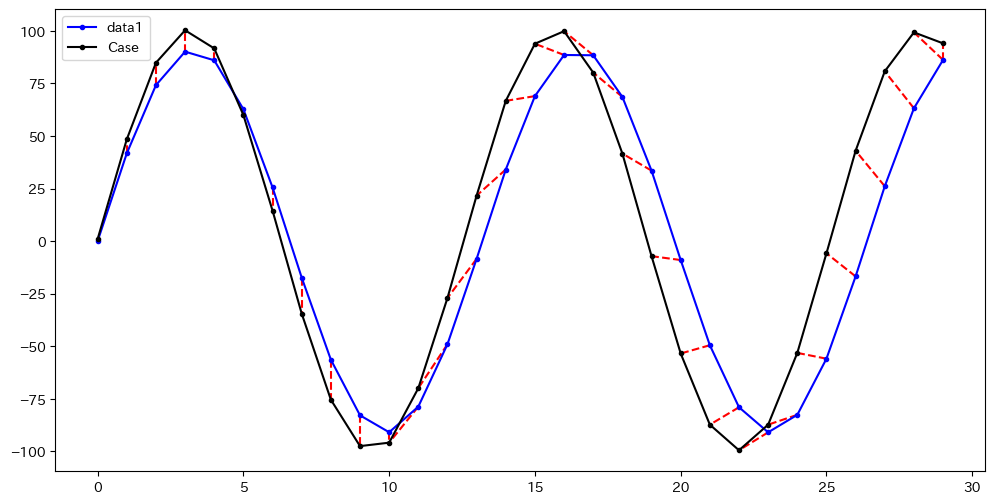

In [10]:
from get_lag_info import *

#DTW例
data1 = [91.0 * np.sin(i / 2.1) for i in range(30)]
data2 = [100.0 * np.sin(i / 2.0) + np.random.rand() for i in range(30)]
data3 = [50.0 * np.cos(i / 2.0) + np.random.rand() for i in range(30)]

plot_shape_dtw(pd.DataFrame(data1), pd.DataFrame(data2), offset=0, label="data1", label2="data2")

実際に下水と感染者数の対応するデータポイントをDTWで求めていく.  
以下のセルの１枚目のグラフは赤線で結ばれた点が対応するデータポイント同士になっており, そのポイント同士のタイムラグを求めたものである.  
２枚目のグラフは定量化したラグをプロットしたものである. 正の値をとる場合が下水が感染者数よりもその値だけ早く変動していることを示す(単位は週).

In [11]:
from numpy.random import randn
from scipy.stats import norm, skewnorm
from shapedtw.shapedtw import shape_dtw
from shapedtw.shapeDescriptors import SlopeDescriptor, PAADescriptor, DerivativeShapeDescriptor, CompoundDescriptor
from shapedtw.dtwPlot import dtwPlot
from shapedtw.shapedtw import DistanceReconstructor

def plot_shape_dtw2(spl, case, label, label2="Case", offset=0.4, lag_series=False):
    slope_descriptor = SlopeDescriptor(slope_window=2)
    paa_descriptor = PAADescriptor(piecewise_aggregation_window=3)
    derivs_descriptor=DerivativeShapeDescriptor()
    # compound_descriptor = CompoundDescriptor([slope_descriptor, derivs_descriptor],descriptors_weights=[5., 1.])
    compound_descriptor = CompoundDescriptor([slope_descriptor, paa_descriptor, derivs_descriptor],descriptors_weights=[5., 1., 1.])

    res = shape_dtw(
        x=spl.to_numpy(),
        y=case.to_numpy(),
        subsequence_width=[3,4,7,8,9,10,20][2],
        shape_descriptor=[slope_descriptor, paa_descriptor, derivs_descriptor,compound_descriptor][-1],
        window_type="sakoechiba",
        window_args={"window_size": 4}, #最大ラグ
        keep_internals=True
    )

    plt.figure()
    k=0
    for a,b in zip(res.index1s, res.index2s):
        if k%3==0:
            plt.plot([case.index[a],case.index[b]], [spl[a]+offset, case[b]], "--r")
        k+=1
    plt.plot(case, "-o",color="0.3", ms=3, label="感染者数")
    plt.plot(spl+offset, "-o", color="tab:blue", ms=3, label="下水１")
    plt.xticks(rotation=45)
    plt.legend(fontsize=12)

    if lag_series:
        plt.figure(figsize=(12,6))
        dist_c=make_lag([(i,k) for i,k in zip(res.index1s, res.index2s)], case)
        dist_c=[math.ceil(i) for i in dist_c]
        plt.plot(dist_c, "-o", ms=2)
        plt.hlines(0, 0, 140, colors="gray", linestyles="dotted")
        plt.text(70, min(dist_c)/2, "下水遅れ")
        plt.text(70, max(dist_c)/2, "下水早い")

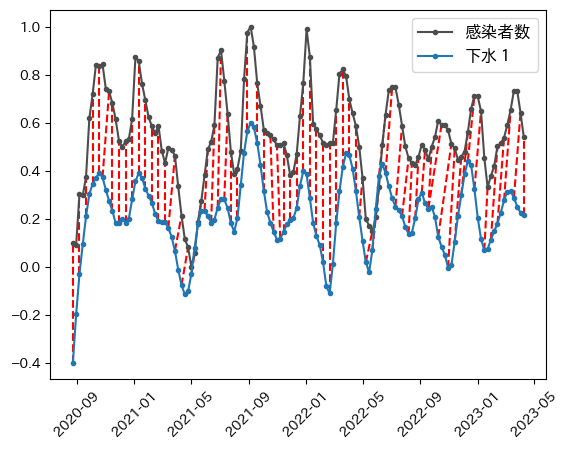

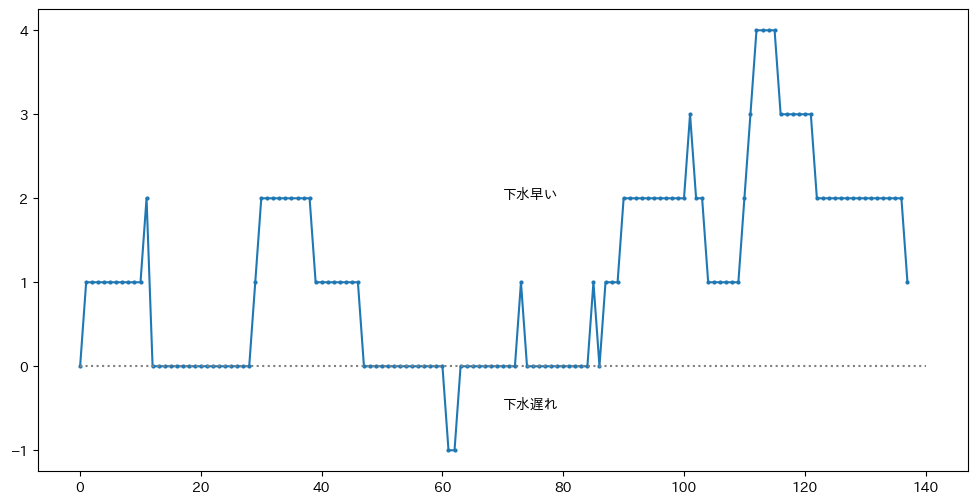

In [12]:
spl_S = (data_sea["spl_S_Seasonal"]-data_sea["spl_S_Seasonal"].min())/(data_sea["spl_S_Seasonal"].max()-data_sea["spl_S_Seasonal"].min())
spl_D = (data_sea["spl_D_Seasonal"]-data_sea["spl_D_Seasonal"].min())/(data_sea["spl_D_Seasonal"].max()-data_sea["spl_D_Seasonal"].min())
spl_M = (spl_S+spl_D)/2
Case = (data_sea["Case_Seasonal"]-data_sea["Case_Seasonal"].min())/(data_sea["Case_Seasonal"].max()-data_sea["Case_Seasonal"].min())

plot_shape_dtw2(spl_S, Case, label="spl_S", offset=-0.4, lag_series=True)
# plot_shape_dtw(spl_D, Case, label="spl_D", offset=-0.4, lag_series=True)

定量化したラグを用いて効率的な感染者数予測を行う

まずは日付ごとに下水データと感染者数のラグをDataFrameにまとめた  
日付ごとに下水と感染者数のラグに対応する列名の要素を１としている

In [13]:
spl_S_lag, spl_D_lag, spl_M_lag = make_spl_lag(spl_S, Case), make_spl_lag(spl_D, Case), make_spl_lag(spl_M, Case)
case_lag=pd.DataFrame(0,index=data_sea.index, columns=[f"lag_{i}"for i in np.arange(-4,7)], dtype=int)
case_lag["lag_0"]=1
case_lag = case_lag.iloc[:,::-1]
spl_S_lag

,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,lag_0,lag_-1,lag_-2,lag_-3,lag_-4
Date,,,,,,,,,,,
2020-08-23,0,0,0,0,0,0,1,0,0,0,0
2020-08-30,0,0,0,0,0,1,0,0,0,0,0
2020-09-06,0,0,0,0,0,1,0,0,0,0,0
2020-09-13,0,0,0,0,0,1,0,0,0,0,0
2020-09-20,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-12,0,0,0,0,1,0,0,0,0,0,0
2023-03-19,0,0,0,0,1,0,0,0,0,0,0
2023-03-26,0,0,0,0,1,0,0,0,0,0,0


ラグを予測に用いる方法について説明する

目的変数のサイズを(1)  
説明変数のサイズを(Time_Step, Features)としたとき  
Time_Stepはデフォルトで６とする  
Featuresは感染者数,及び下水データである  
ラグは日付ごとに求められているので, 説明変数の日付と対応するラグの時点の説明変数を特徴づけるものとして考えられる

例  

目的変数を 2020-10-18 の感染者数とすると, 説明変数は 2020-10-11 からTime_Stepぶん遡った特徴量(感染者数, 下水データ)となる  
2020-10-18 に対応する下水データは, spl_S_lagの 2020-10-18 行を参照するとlag_1つまり１時点前のデータということになる  

目的変数を 2020-10-18 の感染者数として, Time_Stepを６とすると 2020-09-06 ~ 2020-10-11 の特徴量を説明変数として用いることになる  
そして, spl_S_lagの 2020-10-18 行ではlag_1にフラグが立っているので, 2020-10-11の下水データが目的変数と深くかかわっている

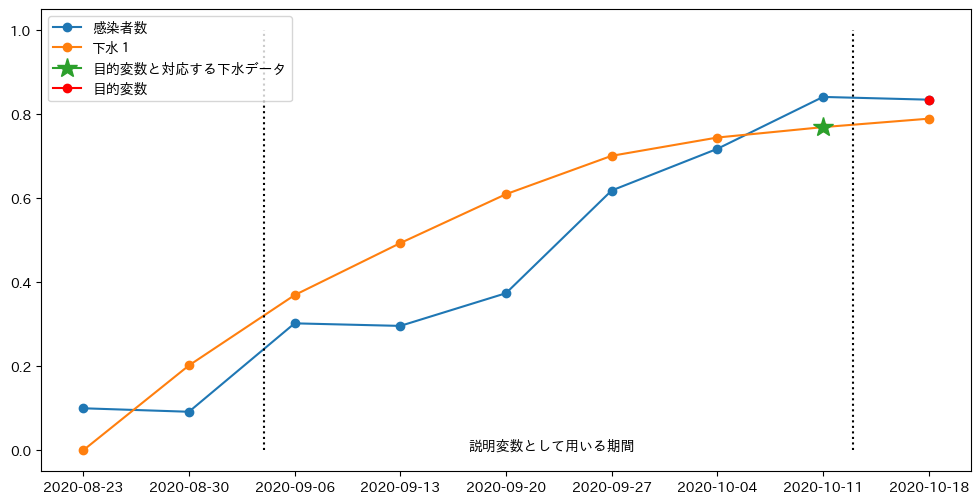

In [14]:
plt.figure(figsize=(12,6))
plt.plot(Case[:"2020-10-18"], "-o", label="感染者数")
plt.plot(spl_S[:"2020-10-18"], "-o", label="下水１")
plt.plot(spl_S["2020-10-10":"2020-10-11"], "-*", ms=15, label="目的変数と対応する下水データ")

plt.xticks(Case[:"2020-10-18"].index)
plt.vlines(datetime.strptime("2020/09/04", '%Y/%m/%d'), 0, 1, color="black", ls="dotted")
plt.vlines(datetime.strptime("2020/10/13", '%Y/%m/%d'), 0, 1, color="black", ls="dotted")
plt.text(datetime.strptime("2020/09/23", '%Y/%m/%d'), 0, "説明変数として用いる期間", ha="center")

plt.plot(Case["2020-10-17":"2020-10-18"], "-or", label="目的変数")
plt.legend()
plt.show()

このように説明変数(下水データ)をラグ情報によって特徴づけることが可能となる  
しかし, これは目的変数と対応する時点が説明変数として用いる期間に含まれている場合に限られる  

この問題は以下の手順で解決する

ラグ情報をワンホットベクトルとして扱うのではなく, フラグが立っている時点で最大値をとるガウス関数を用いる
これにより, 説明変数として用いる期間の下水データ全てに対して, 目的変数とのラグ関係性を与えることができる  

ラグ情報をワンホットベクトルでDataFrame化した spl_S_lag 等をガウス関数で置き換えたDataFrameにしていく  
これをラグ重要度と呼び, 以下で作成する

In [15]:
norm_S_lag = norm_lag_df(spl_S_lag)
norm_D_lag = norm_lag_df(spl_D_lag)
norm_M_lag = norm_lag_df(spl_M_lag)
norm_C_lag = norm_lag_df(case_lag)

In [16]:
norm_S_lag

,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1
Date,,,,,,
2020-08-23,-0.049361,-0.046152,-0.033274,0.002448,0.068645,0.143627
2020-08-30,-0.046152,-0.033274,0.002448,0.068645,0.143627,0.177967
2020-09-06,-0.046152,-0.033274,0.002448,0.068645,0.143627,0.177967
2020-09-13,-0.046152,-0.033274,0.002448,0.068645,0.143627,0.177967
2020-09-20,-0.046152,-0.033274,0.002448,0.068645,0.143627,0.177967
...,...,...,...,...,...,...
2023-03-12,-0.033274,0.002448,0.068645,0.143627,0.177967,0.143627
2023-03-19,-0.033274,0.002448,0.068645,0.143627,0.177967,0.143627
2023-03-26,-0.033274,0.002448,0.068645,0.143627,0.177967,0.143627


In [17]:
spl_S_lag

,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,lag_0,lag_-1,lag_-2,lag_-3,lag_-4
Date,,,,,,,,,,,
2020-08-23,0,0,0,0,0,0,1,0,0,0,0
2020-08-30,0,0,0,0,0,1,0,0,0,0,0
2020-09-06,0,0,0,0,0,1,0,0,0,0,0
2020-09-13,0,0,0,0,0,1,0,0,0,0,0
2020-09-20,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-12,0,0,0,0,1,0,0,0,0,0,0
2023-03-19,0,0,0,0,1,0,0,0,0,0,0
2023-03-26,0,0,0,0,1,0,0,0,0,0,0


求めたラグ重要度は下水１及び下水２, そして感染者数データに対してである.  
ただし感染者数データのラグ重要度はすべての時点で lag_0 , つまり目的変数の時点を最大値とするガウス関数を用いた

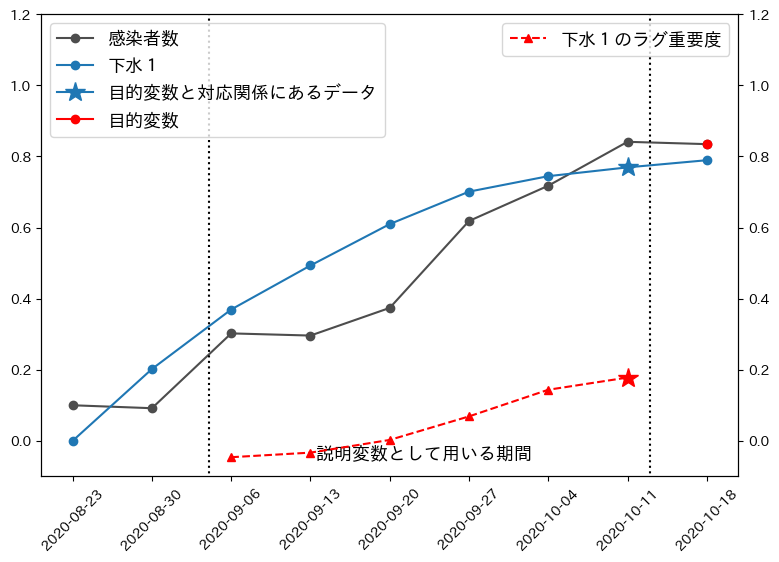

In [18]:
plt.figure(figsize=(9,6))
plt.plot(Case[:"2020-10-18"], "-o", color="0.3", label="感染者数")
plt.plot(spl_S[:"2020-10-18"], "-o", color="tab:blue", label="下水１")
plt.plot(spl_S["2020-10-10":"2020-10-11"], "-*", ms=15, label="目的変数と対応関係にあるデータ")

plt.xticks(Case[:"2020-10-18"].index)
plt.vlines(datetime.strptime("2020/09/04", '%Y/%m/%d'), -0.2, 1.2, color="black", ls="dotted")
plt.vlines(datetime.strptime("2020/10/13", '%Y/%m/%d'), -0.2, 1.2, color="black", ls="dotted")
plt.ylim([-0.1,1.2])
plt.text(datetime.strptime("2020/09/23", '%Y/%m/%d'), -0.05, "説明変数として用いる期間", ha="center", fontsize=13)
plt.plot(Case["2020-10-17":"2020-10-18"], "-or", label="目的変数")
plt.legend(loc="upper left", fontsize=13)
plt.xticks(rotation=45)

plt.twinx()
plt.plot(spl_S["2020-09-06":"2020-10-11"].index, norm_S_lag.loc["2020-10-18",:], "--^r", label="下水１のラグ重要度")
plt.plot(spl_S["2020-10-10":"2020-10-11"].index, norm_S_lag.loc["2020-10-18"][-1], "-*r", ms=15)
# plt.plot(Case["2020-09-06":"2020-10-11"].index, norm_C_lag.loc["2020-10-18",:], "--^", label="(感染者のラグ重要度)")
plt.xticks(Case[:"2020-10-18"].index)
plt.ylim([-0.1,1.2])
plt.legend(loc="upper right", fontsize=13)
plt.show()


In [19]:
norm_S_lag.loc["2020-10-18"][-1]

0.17796701737224724

以上で感染者数と下水データ(感染者数)とのラグ重要度を定義できた  
現在所有している特徴量は 感染者数, 下水１, 下水２, ラグ重要度下水１, ラグ重要度下水２, ラグ重要度感染者数 の６つである  

目的変数のサイズは(1)  
説明変数のサイズは(Time_Step, Features)であったので, これにあてはめると  

目的変数のサイズは(1)  
説明変数のサイズは(6, 6)となる  
Time_Stepは経験的に6としている

これから予測を行っていく前にデータの正規化と整形をする

In [20]:
test_size = 35

#正規化
max_=data_sea[:-test_size].max()
min_=data_sea[:-test_size].min()
print(max_, min_)

mm_data_sea = (data_sea-min_)/(max_ - min_)
mm_data_sea

def minmax(data):
    max_=data[:-test_size].max().max()
    min_=data[:-test_size].min().min()
    return (data-min_)/(max_-min_)


norm_S_lag = minmax(norm_S_lag)
norm_D_lag = minmax(norm_D_lag)
norm_M_lag = minmax(norm_M_lag)
norm_C_lag = minmax(norm_C_lag)

Case_Seasonal     1.172088
spl_S_Seasonal    1.397462
spl_D_Seasonal    1.610843
dtype: float64 Case_Seasonal    -1.410157
spl_S_Seasonal   -2.205429
spl_D_Seasonal   -1.140278
dtype: float64


In [21]:
RNN_data_sea=[]
for i in range(5,len(mm_data_sea)-1):
    tmp=mm_data_sea.iloc[i-5:i+1,:]
    RNN_data_sea.append(tmp)

y_RNN_sea=mm_data_sea["Case_Seasonal"].shift(-1)[5:-1]

X_RNN_sea_train = RNN_data_sea[:-test_size]
X_RNN_sea_test = RNN_data_sea[-test_size:]
X_RNN_sea_train = np.array([i.to_numpy() for i in X_RNN_sea_train])
X_RNN_sea_test = np.array([i.to_numpy() for i in X_RNN_sea_test])


#横に連結
lag_tmp=[]
for i in range(len(X_RNN_sea_train)):
    tmp=np.vstack([norm_C_lag.iloc[i+6,:].to_numpy(), norm_S_lag.iloc[i+6,:].to_numpy(), norm_D_lag.iloc[i+6,:].to_numpy()]).T
    lag_tmp.append(tmp)

X_RNN_sea_train = np.concatenate((X_RNN_sea_train, lag_tmp), axis=2)

lag_tmp=[]
for i in range(len(X_RNN_sea_train), len(RNN_data_sea)):
    tmp=np.vstack([norm_C_lag.iloc[i+6,:].to_numpy(), norm_S_lag.iloc[i+6,:].to_numpy(), norm_D_lag.iloc[i+6,:].to_numpy()]).T
    lag_tmp.append(tmp)

X_RNN_sea_test = np.concatenate((X_RNN_sea_test, lag_tmp), axis=2)


y_RNN_sea_train = y_RNN_sea[:-test_size]
y_RNN_sea_test = y_RNN_sea[-test_size:]

print(RNN_data_sea)

[            Case_Seasonal  spl_S_Seasonal  spl_D_Seasonal
Date                                                     
2020-08-23       0.099997        0.000000        0.000000
2020-08-30       0.091708        0.201990        0.123756
2020-09-06       0.302232        0.369462        0.227910
2020-09-13       0.296141        0.493313        0.344922
2020-09-20       0.373982        0.609763        0.476631
2020-09-27       0.618486        0.701086        0.594636,             Case_Seasonal  spl_S_Seasonal  spl_D_Seasonal
Date                                                     
2020-08-30       0.091708        0.201990        0.123756
2020-09-06       0.302232        0.369462        0.227910
2020-09-13       0.296141        0.493313        0.344922
2020-09-20       0.373982        0.609763        0.476631
2020-09-27       0.618486        0.701086        0.594636
2020-10-04       0.717746        0.744632        0.658909,             Case_Seasonal  spl_S_Seasonal  spl_D_Seasonal
Date       

In [22]:
print(X_RNN_sea_train.shape) #trainデータの説明変数のサイズ
print(y_RNN_sea_train.shape) #trainデータの目的変数のサイズ
print(X_RNN_sea_test.shape) #testデータの説明変数のサイズ
print(y_RNN_sea_test.shape) #testデータの目的変数のサイズ

(97, 6, 6)
(97,)
(35, 6, 6)
(35,)


予測に用いるモデルはベースラインとしてLSTM   
提案モデルとしてセルフアテンションを用いたモデル とした

セルフアテンションを使用する理由  
異なる時点間の依存性を効果的にモデリングするため  
ここでは, 説明変数の下水データとラグ情報量の依存関係を指す

一般的にトランスフォーマーモデルではアテンション機構の前に, 入力データに位置情報を与えるPositionalEncodingを使用する  
作成したラグ重要度をこのPositionalEncodingのように用いられるのではないかと考えた  
実験を繰り返した結果, ラグ重要度を下水データや感染者数と合わせて入力とする自作のEncoding層に, PositionalEncodingのような役割を持たせることにした


In [23]:
from transformer_encoder import *

In [24]:
def tf_enc(inputs, head_size, num_heads, ff_dim, dropout, LN):
    if LN=="B2T":#B2T connection
        x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
        x = Dropout(dropout)(x)
        res = x + inputs
        res = LayerNormalization(epsilon=1e-6)(res)
        # Feed Forward Part
        x = Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
        x = Dropout(dropout)(x)
        x = Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
        x = x + res + inputs
        x =  LayerNormalization(epsilon=1e-6)(x)
        return x

    if LN=="pre":# Normalization then Attention
        x = LayerNormalization(epsilon=1e-6)(inputs)
        # x = Permute((2,1))(x)
        x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x = Dropout(dropout)(x)
        # x = Permute((2,1))(x)
        # x = My_mha(hidden_dim=head_size, head_num=num_heads, dropout_rate=0.0)(x,x)
        res = x + inputs
        # Feed Forward Part
        x = LayerNormalization(epsilon=1e-6)(res)
        x = Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
        # x = GRU(ff_dim, return_sequences=True)(x)
        x = Dropout(dropout)(x)
        x = Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
        # x = GRU(inputs.shape[-1], return_sequences=True)(x)
        return x + res

    if LN=="post":#Attention then Normalization
        x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
        x = Dropout(dropout)(x)
        res = x + inputs
        res = LayerNormalization(epsilon=1e-6)(res)
        # Feed Forward Part
        x = Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
        x = Dropout(dropout)(x)
        x = Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
        # x = GRU(ff_dim, return_sequences=True, activation="relu")(res)
        # x = Dropout(dropout)(x)
        # x = GRU(inputs.shape[-1], return_sequences=True, activation="relu")(x)

        x = x + res
        x =  LayerNormalization(epsilon=1e-6)(x)
        return x

    raise ValueError("LNが無効な変数です")

def build_model(
    input_,
    # target,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    dropout,
    LN="pre",
    GAP=True
):
    x = input_
    for _ in range(num_transformer_blocks):
        x = tf_enc(x, head_size, num_heads, ff_dim, dropout, LN)

    if LN=="pre":
        x=LayerNormalization(epsilon=1e-6)(x)

    if GAP:
        x = GlobalAveragePooling1D(data_format="channels_first")(x)
        # x = GlobalAveragePooling1D(data_format="channels_last")(x)
#     x = Flatten()(x)
    return x

In [25]:
def base_LSTM():
    inputs=Input(shape=(6,3))
    x=Bidirectional(GRU(15, return_sequences=True))(inputs)
    x=Bidirectional(GRU(15, return_sequences=False))(x)
    x=Dense(8)(x)
    x=Dense(1, activation="linear")(x)
    model = Model(inputs=inputs, outputs=x)
    return model


def proposed_model():
    inputs=[Input(shape=(6,3)), Input(shape=(6,3))] #[感染者, 下水1, 下水2], [ラグ重要度感染者数、ラグ重要度下水1、ラグ重要度下水2]
    lag_enc = Bidirectional(GRU(6, return_sequences=True, activation="relu"))(Concatenate(axis=-1)([inputs[0], inputs[1]])) #

    x = build_model(
        input_=Concatenate(axis=-1)([inputs[0], lag_enc]),
        head_size=16,
        num_heads=6,
        ff_dim=30,
        num_transformer_blocks=4,
        dropout=0.1,
        LN="pre",
        GAP=False
    )

    x=Conv1D(filters=6, kernel_size=1, activation="relu")(x)
    # x=Concatenate(axis=-1)([x, inputs[0]])

    # x=Bidirectional(GRU(8, return_sequences=False, activation="relu"))(x)
    x=Concatenate(axis=-1)([x, inputs[0]])
    # x=Concatenate(axis=-1)([x, Bidirectional(GRU(8, return_sequences=False, activation="relu"))(inputs[0])])
    # x=Dropout(0.1)(x)
    # x=Bidirectional(GRU(15, return_sequences=False, activation="relu"))(Concatenate(axis=-1)([inputs[0], lag_enc]))
    # x=Flatten()(x)
    # x=Dense(32, activation="relu")(x)
    x=Bidirectional(GRU(8, return_sequences=False, activation="relu"))(x)
    x=Dropout(0.1)(x)
    x=Dense(16, activation="relu")(x)
    x=Dropout(0.1)(x)
    x=Dense(1, activation="linear")(x)
    model = Model(inputs=inputs, outputs=x)
    return model

入力するデータは\[ \[感染者数, 下水１, 下水２\], \[ラグ重要度感染者数, ラグ重要度下水１, ラグ重要度下水２\] \]  
サイズは(6, 6) = ( (6,3), (6,3) )である  


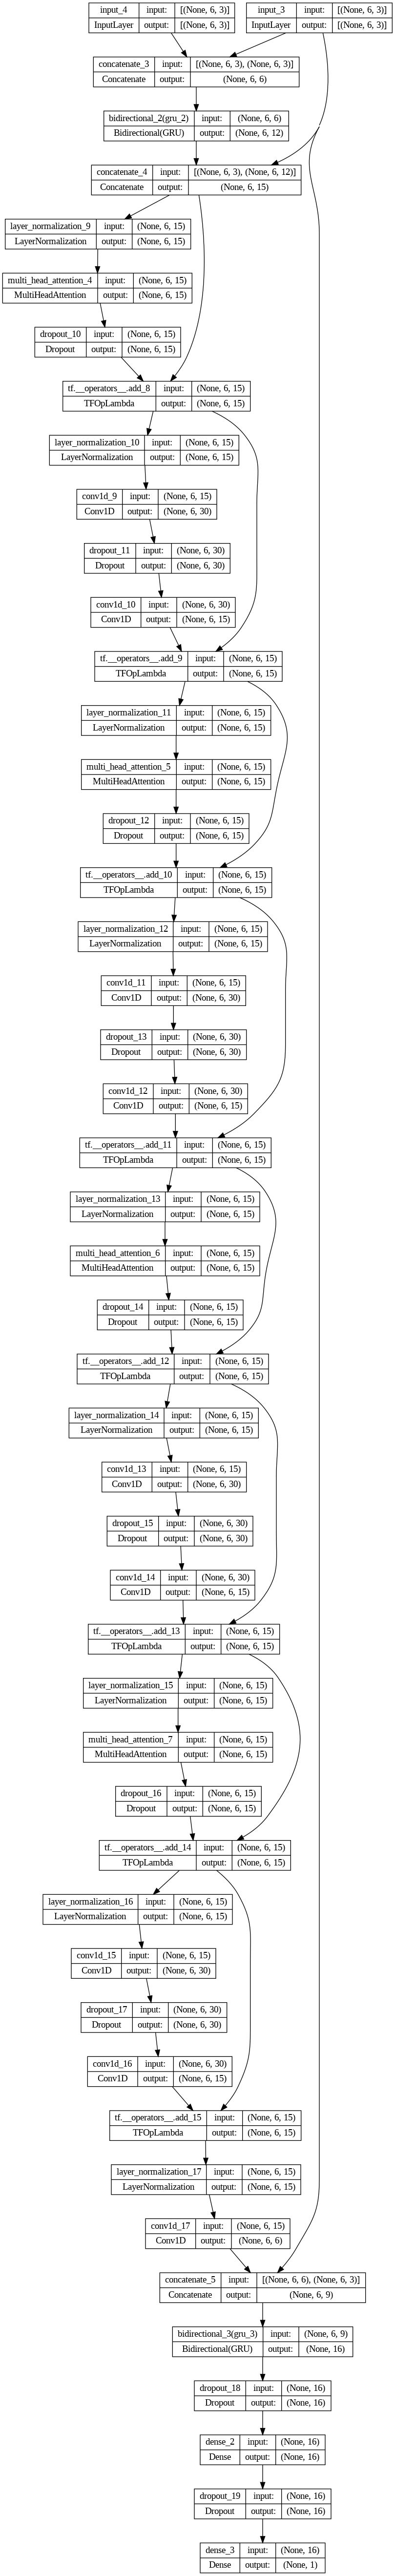

In [33]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# model = base_LSTM()
model = proposed_model()
loss_function="mean_squared_error"
model.compile(loss=loss_function, optimizer=keras.optimizers.Adam(learning_rate=0.001))
plot_model(model,show_shapes=True)

学習を行う

In [27]:
tf.config.experimental.enable_op_determinism()

In [34]:
def set_seed(seed=200):
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    # optional
    # for numpy.random
    np.random.seed(seed)
    # for built-in random
    random.seed(seed)
    # for hash seed
    # os.environ["PYTHONHASHSEED"] = str(seed)


# EaelyStoppingの設定
# tf.random.set_seed(1234)
cp = ModelCheckpoint("weights.hdf5", monitor="val_loss", verbose=1,
                     save_best_only=True, save_weights_only=True)

es =  EarlyStopping(monitor='val_loss',
                                min_delta=1e-3,
                                patience=150,
                                mode="min")

def step_decay(epoch):
    x = 0.01
    if epoch >= 100: x = 0.001
    # if epoch >= 225: x = 0.001
    return x
lr_decay = LearningRateScheduler(step_decay)

# 学習の実行
set_seed(1)
history = model.fit(
                    [X_RNN_sea_train[:,:,:3],  X_RNN_sea_train[:,:,3:]] ,y_RNN_sea_train,
                    # X_RNN_sea_train[:,:,:3] ,y_RNN_sea_train,
                    epochs=100,
                    batch_size=3,
                    validation_split=0.2,
                    # callbacks=[cp],
                    # callbacks=[es],
                    callbacks=[cp,es,lr_decay],
                    verbose=1,

                    shuffle=False)

Epoch 1/100
25/26 [===========================>..] - ETA: 0s - loss: 0.1959
Epoch 1: val_loss improved from inf to 0.05595, saving model to weights.hdf5
26/26 [==============================] - 23s 100ms/step - loss: 0.1911 - val_loss: 0.0560 - lr: 0.0100
Epoch 2/100
24/26 [==========================>...] - ETA: 0s - loss: 0.0940
Epoch 2: val_loss improved from 0.05595 to 0.05586, saving model to weights.hdf5
26/26 [==============================] - 1s 35ms/step - loss: 0.0903 - val_loss: 0.0559 - lr: 0.0100
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 0.0904
Epoch 3: val_loss improved from 0.05586 to 0.04272, saving model to weights.hdf5
26/26 [==============================] - 1s 36ms/step - loss: 0.0904 - val_loss: 0.0427 - lr: 0.0100
Epoch 4/100
25/26 [===========================>..] - ETA: 0s - loss: 0.0755
Epoch 4: val_loss improved from 0.04272 to 0.03511, saving model to weights.hdf5
26/26 [==============================] - 1s 36ms/step - loss: 0.0763 - 

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6, 3)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 6, 3)]       0           []                               
                                                                                                  
 concatenate_3 (Concatenate)    (None, 6, 6)         0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 6, 12)       504         ['concatenate_3[0][0]']    

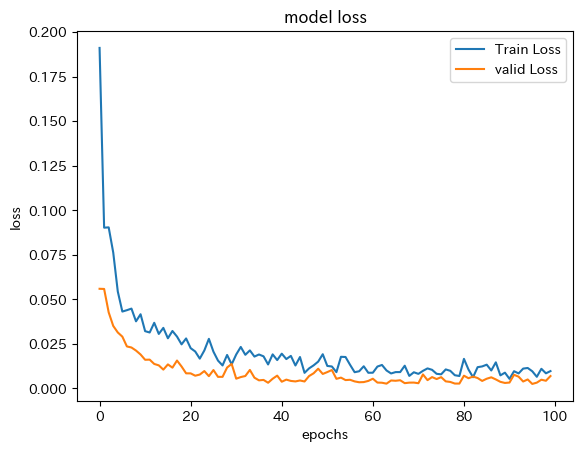

In [35]:
model.summary()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='valid Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

In [36]:
y_test_pred =model.predict([X_RNN_sea_test[:,:,:3], X_RNN_sea_test[:,:,3:]])
# _y_test_pred =model.predict(X_RNN_sea_test[:,:,:3])

y_train_pred =model.predict([X_RNN_sea_train[:,:,:3], X_RNN_sea_train[:,:,3:]])
# _y_train_pred =model.predict(X_RNN_sea_train[:,:,:3])

4/4 [==============================] - 0s 23ms/step


予測結果を以下に示す

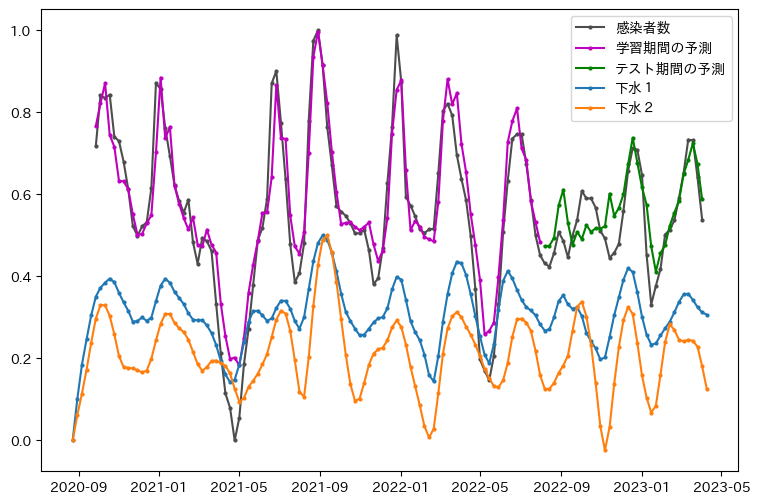

In [37]:
plt.figure(figsize=(9,6))
plt.plot(y_RNN_sea, "-o", color="0.3", ms=2, label="感染者数")
plt.plot(y_RNN_sea[:-test_size].index, y_train_pred, "-om", ms=2, label="学習期間の予測")
plt.plot(y_RNN_sea[-test_size:].index,y_test_pred, "-og", ms=2, label="テスト期間の予測")
plt.legend()

plt.plot(mm_data_sea[["spl_S_Seasonal","spl_D_Seasonal"]]/2, "-o", ms=2, label=["下水１","下水２"])
plt.legend()

評価

In [38]:
v=val(y_test_pred, y_RNN_sea[-test_size:], y_RNN_sea[:-test_size])

RMSE: 0.06575824785769217
MAPE: 10.702356370169404
MASE: 0.6607030444055243


In [39]:
!git --version

git version 2.34.1
